In [15]:
import cv2
from cv2 import threshold
import numpy as np
import sys
import os
import json
from torchvision import models
from tqdm import tqdm
from pytorch3d.renderer import look_at_view_transform
from math import ceil
import torch
from pytorch3d.io import load_obj, load_ply
from scipy.spatial.transform import Rotation as scipy_rot
from matplotlib import pyplot as plt
from probabilistic_formulation.tests.test_factors_lines import create_k3d_plot
import random

%load_ext autoreload
%autoreload 2

from leveraging_geometry_for_shape_estimation.keypoint_matching.get_matches_3d import load_information_depth_camera,create_pixel_bearing,pb_and_depth_to_wc
from leveraging_geometry_for_shape_estimation.probabilistic_pose_and_shape.pose import init_Rs,init_Ts,get_pb_real_grid,get_R_limits,get_T_limits, create_pose_info_dict, check_gt_pose_in_limits, get_nearest_pose_to_gt
from leveraging_geometry_for_shape_estimation.probabilistic_pose_and_shape.translation_from_lines_v2 import *
from leveraging_geometry_for_shape_estimation.probabilistic_pose_and_shape.ground_plane import get_model_to_infos,sample_Ts_ground_plane,filter_Ts
from probabilistic_formulation.utilities import create_all_possible_combinations,get_uvuv_p_from_superpoint,create_all_possible_combinations_uvuv_p_together
from probabilistic_formulation.factors import get_factor_bbox_multiple_T, get_factor_reproject_lines_multiple_T,get_factor_reproject_kp_multiple_T, get_factor_reproject_lines_multiple_T_with_Scale
from probabilistic_formulation.tests.test_reproject_lines import load_lines_2D,load_lines_3D,get_cuboid_line_dirs_3D,plot_lines_T,plot_bbox, plot_points_T


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# global_info = '/scratches/octopus_2/fml35/experiments/leveraging_geometry_for_shape/exp_165_roca_retrieval_no_z_gt_scale_fix_z_limits/global_information.json'
# global_info = '/scratches/octopus_2/fml35/experiments/leveraging_geometry_for_shape/exp_183_roca_retrieval_gt_z_lines/global_information.json'
global_info = '/scratches/octopus_2/fml35/experiments/leveraging_geometry_for_shape/exp_186_roca_retrieval_gt_z_lines_octopus/global_information.json'
with open(global_info,'r') as f:
    global_config = json.load(f)

global_config["pose_and_shape_probabilistic"]["reproject_lines"]["line_dir_3d_precise"] = global_config["pose_and_shape_probabilistic"]["reproject_lines"]["line_dir_3d_precise"].replace('/scratch2/','/scratches/octopus_2/')

global_config["pose_and_shape_probabilistic"]["sample_in_ground_plane"] = 'False'
# global_config["pose_and_shape_probabilistic"]["ground_plane_limits"]["camera_heights"] = [0.5,0.9]#[0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8]
global_config["pose_and_shape_probabilistic"]["reproject_lines"]["multiplier_lines"] = 0.1
global_config["pose_and_shape_probabilistic"]["reproject_lines"]["signal"] = "lines"
global_config["pose_and_shape_probabilistic"]["reproject_lines"]["enforce_same_length"] = True


use_gt_retrieval = False
use_gt_R = False
point_size = 0.03
line_indices = None

In [17]:

target_folder,models_folder_read,top_n_retrieval,top_n_for_translation,pose_config,sensor_width,device = get_variables(global_config)
target_folder = target_folder.replace('/scratch2/','/scratches/octopus_2/')
models_folder_read = models_folder_read.replace('/scratch2/','/scratches/octopus_2/')

model_to_infos = get_model_to_infos()

poses_R_names = os.listdir(target_folder + '/poses_R')

random.shuffle(poses_R_names)

distances_to_gt = []

for iter_count in tqdm(range(2000)):
    name = poses_R_names[iter_count]


    retrieval = name.rsplit('_',1)[0]
    detection = name.rsplit('_',2)[0]
    gt_name = name.rsplit('_',3)[0]
    nn_index = int(retrieval.split('_')[-1])

    visualisation_list,retrieval_list,gt_infos,segmentation_infos,bbox_overlap = load_infos(target_folder,detection,gt_name)
    output_path = target_folder + '/poses/' + name
    if use_gt_retrieval:
        retrieval_list[nn_index]["model"] = gt_infos["objects"][bbox_overlap['index_gt_objects']]["model"]

    # input_img = cv2.imread(target_folder + '/images/' + gt_infos['img'])
    # lines = cv2.imread(target_folder + '/lines_2d_filtered_vis/' + detection + '.png')
    # plt.imshow(input_img)
    # plt.show()

    f,w,h,sw,enforce_same_length,gt_rot,gt_trans,gt_scaling,gt_z = get_infos_gt(gt_infos,pose_config,global_config,bbox_overlap)
    # B = get_pb_real_grid(w,h,f,sw,device)
    bbox = segmentation_infos["predictions"]["bbox"]
    model_path = retrieval_list[nn_index]["model"]

    if use_gt_R:
        R = gt_infos["objects"][bbox_overlap['index_gt_objects']]["rot_mat"]
    else:
        with open(target_folder + '/poses_R/' + name,'r') as file:
            R = json.load(file)["predicted_r"]


    # sp_rot = scipy_rot.from_matrix(R)
    # tilt,azim,elev = sp_rot.as_euler('zyx',degrees=True)
    # tilts,azims,elevs = [tilt-0.0001,tilt+0.0001,1],[azim-0.0001,azim+0.0001,1],[elev-0.0001,elev+0.0001,1]

    Ss = np.reshape(np.array(gt_scaling),(1,3))


    # SAMPLES TS
    xs,ys,zs = get_T_limits(f,[w,h],sensor_width,global_config["pose_and_shape_probabilistic"]["pose"],bbox,gt_z)
    if global_config["pose_and_shape_probabilistic"]["sample_in_ground_plane"] == "True":
        Ts = get_Ts_ground_plane(model_path,model_to_infos,gt_scaling,global_config,segmentation_infos,f,sw,w,h,R)
        
    elif global_config["pose_and_shape_probabilistic"]["sample_in_ground_plane"] == "False":
        Ts = init_Ts(xs,ys,zs)

    if Ts.shape[0] == 0:
        Ts = np.array([[0,0,1]])

    # print(Ts)
    # print(global_config["pose_and_shape_probabilistic"]["pose"])
    Ts = torch.Tensor(Ts)
    closest_gt_t_index = get_closest_index(Ts,gt_trans)

    T_closest_gt = Ts[closest_gt_t_index].numpy()

    # print('T_closest_gt',T_closest_gt)
    # print('gt_trans',gt_trans)

    distance = np.linalg.norm(T_closest_gt - gt_trans)
    # print('distance',distance)
    distances_to_gt.append(distance)
    continue
    within_01 = distance < 0.1
    print('within_01',within_01)

    # compute factors
    Ts = torch.Tensor(Ts)
    signal = global_config["pose_and_shape_probabilistic"]["reproject_lines"]["signal"]
    if signal == 'bbox' or signal == 'lines':
        best_T_index,best_S_index,max_factor,lines_3D,lines_2D,lines_available,multiplier_lines,factors = signal_bbox_or_line(global_config,model_path,target_folder,detection,device,R,Ts,bbox,f,w,h,sw,Ss,B,enforce_same_length,top_n_for_translation,line_indices)
        for line in lines_2D:
            y_start, x_start, y_end, x_end = [int(val) for val in line]
            cv2.line(input_img, (x_start, y_start), (x_end, y_end), [255,0,0], 2)
        # plt.imshow(input_img)
        # plt.show()
    elif signal == 'points':
        best_T_index,max_factor,points_2D,points_available,points_3D,multiplier_points,point_threshold,use_threshold = signal_points(global_config,model_path,target_folder,detection,device,R,Ts,B,top_n_for_translation,f)
        
    create_k3d_plot(np.array(Ts),np.array(factors),gt_trans,point_size)
    T = Ts[best_T_index]
    S = Ss[best_S_index]

    # print('T',T)
    # print('S',S)
    # print('R',R)


 23%|██▎       | 469/2000 [03:13<08:05,  3.15it/s]

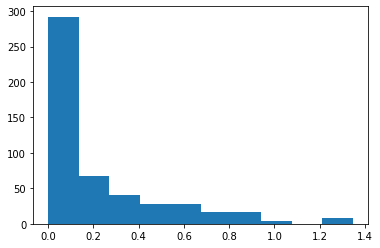

In [13]:
plt.hist(distances_to_gt)
plt.show()

In [ ]:

create_k3d_plot(np.array(Ts),np.array(factors),gt_trans,point_size)
T = Ts[best_T_index]
S = Ss[best_S_index]

print('T',T)
print('S',S)
print('R',R)


Output()

T tensor([0.0954, 0.3777, 1.4760])
S [2.12771383 4.12588462 2.30721931]
R [[-0.7905197370115368, 0.28772565387214566, -0.5406408174555974], [0.6082832725385413, 0.26623747397519565, -0.7477359612865422], [-0.0712039728176247, -0.9199628011801091, -0.385484680240128]]


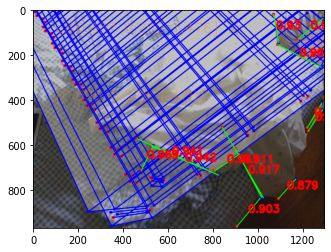

In [ ]:
n_indices = 1
# pose_information = create_pose_info_dict(np.array(R),T,n_indices,max_factor,gt_pose_in_limits,gt_rot,gt_trans,best_R_possible,best_T_possible,xs,ys,zs,tilts,elevs,azims,gt_scaling)
# with open(output_path,'w') as open_f:
#     json.dump(pose_information,open_f,indent=4)



closest_gt_t_index = get_closest_index(Ts,gt_trans)
closest_gt_s_index = get_closest_index(torch.Tensor(Ss),gt_scaling)

# for which,l,s in zip(['selected','closest_gt'],[best_T_index,closest_gt_t_index],[best_S_index,closest_gt_s_index]):
for which,l,s in zip(['selected'],[best_T_index],[best_S_index]):
    T = Ts[l]
    S = Ss[s]
    img_path = target_folder + '/images/' + gt_infos["img"]
    full_model_path = global_config["dataset"]["dir_path"].replace('/scratch2/','/scratches/octopus_2/') + model_path

    if signal == 'bbox':
        if not lines_3D.shape[0] == 0:
            img = plot_bbox(torch.Tensor(R).unsqueeze(0),torch.Tensor(T).unsqueeze(0).unsqueeze(0),gt_scaling,full_model_path,img_path,sw,device,lines_3D,f,torch.Tensor(bbox))
    elif signal == 'lines':
        if lines_available:
            img = plot_lines_T(torch.Tensor(R).unsqueeze(0),torch.Tensor(T).unsqueeze(0).unsqueeze(0),S,full_model_path,img_path,sw,device,lines_3D,lines_2D,B,f,top_n_for_translation,multiplier_lines,enforce_same_length)
        else:
            img = cv2.imread(target_folder + '/images/' + gt_infos["img"])
    elif signal == 'points':
        if points_available:
            img = plot_points_T(torch.Tensor(R).unsqueeze(0),torch.Tensor(T).unsqueeze(0).unsqueeze(0),gt_scaling,full_model_path,img_path,sw,device,points_3D,points_2D,B,f,top_n_for_translation,multiplier_points,point_threshold,use_threshold)
        else:
            img = cv2.imread(target_folder + '/images/' + gt_infos["img"])

    cv2.putText(img, 'gt' + str(np.round(gt_trans,3)), (100,100), cv2.FONT_HERSHEY_SIMPLEX, 2,(255, 128, 0), 1, cv2.LINE_AA)
    cv2.putText(img, str(np.round(T.numpy(),3)), (100,400), cv2.FONT_HERSHEY_SIMPLEX, 2,(255, 128, 0), 1, cv2.LINE_AA)
    plt.imshow(img)
    plt.show()